<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic7/Chollet_HFST7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

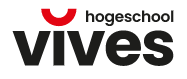<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# HFST 7: Working with Keras - a deep dive

Import statements

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.datasets import mnist

## 7.2. Different ways to build Keras models

### 7.2.1. The Sequential Model

List van layers doorgeven aan constructor:

In [ ]:
model = keras.Sequential([
    layers.Dense(64, 'relu'),
    layers.Dense(10, 'softmax')
])

In [ ]:
#model.build()  # lukt niet want input_shape nodig voor het initialiseren van de gewichten!
model.build(input_shape=(None, 3))

In [ ]:
model.summary()  # lukt enkel als model is geconstrueerd met methode build()

Kan je het aantal parameters verklaren?

Met methode `add()` werken:

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(64, 'relu'))
model.add(layers.Dense(10, 'softmax'))

In [ ]:
model.build(input_shape=(None, 3))

In [ ]:
model.summary()

Input layer direct meegeven:

In [ ]:
model = keras.Sequential([
    layers.Input(shape=(3,)),  # waarom (3,) en niet gewoon 3??
    layers.Dense(64, 'relu'),
    layers.Dense(10, 'softmax')
])
model.build()
model.summary()

In [ ]:
model = keras.Sequential(name="Model")
model.add(layers.Input(shape=(3,), name="Input"))
model.add(layers.Dense(units=64, activation='relu', name="Hidden"))
model.add(layers.Dense(units=10, activation='softmax', name="Output"))
model.build()
model.summary()

### 7.2.2. The functional API

Previous example with functional API:

In [ ]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

In [ ]:
for tensor in [inputs, features, outputs]:
    print(tensor.shape)  # symbolic tensors! bevatten nog geen data!
    print(tensor.dtype)

Multi-input multi-output example: customer support tickets

In [ ]:
# the model

vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department]
)

In [ ]:
# the (random) data

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

Model compileren, trainen en evalueren:

met lists - volgorde belangrijk!

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]]
)

model.fit(
    [title_data, text_body_data, tags_data],  # volgorde belangrijk!
    [priority_data, department_data],  # volgorde belangrijk!
    epochs=1
)

model.evaluate(
    [title_data, text_body_data, tags_data],  # volgorde belangrijk!
    [priority_data, department_data]  # volgorde belangrijk!
)

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])  # volgorde belangrijk!

met dicts - volgorde niet belangrijk!

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department":"categorical_crossentropy"},
    metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]}
)

model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1
)

model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    {"priority": priority_data, "department": department_data}
)

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

Model plotten:

In [ ]:
#keras.utils.plot_model(model, "ticket_classifier.png")
keras.utils.plot_model(model)

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Layers opvragen:

In [ ]:
model.layers  # list

Layer input en output opvragen:

In [ ]:
print(model.layers[4].input)
print(model.layers[4].output)

Model uitbreiden:

In [ ]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)  # 3 categorieën

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty]
)

keras.utils.plot_model(new_model)

### 7.2.3. Subclassing the `Model` class

In [ ]:
class CustomerTicketModel(keras.Model):  # erft van keras.Model!

    def __init__(self, num_departments):
        super().__init__()  # niet vergeten!
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
        num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [ ]:
model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)  # roept method call() aan

In [ ]:
# erft methoden compile(), fit(), evaluate(), predict()

model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]]
)

model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
    epochs=1
)

model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data]
)

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

## 7.3. Using built-in training and evaluation loops

In [ ]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [ ]:
model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.fit(
    train_images, train_labels,
    epochs=3,
    validation_data=(val_images, val_labels)
)

test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

### 7.3.1. Writing your own metrics

In [ ]:
class RootMeanSquaredError(keras.metrics.Metric):  # erft van keras.metrics.Metric!

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)  # niet vergeten!
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [ ]:
model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", RootMeanSquaredError()]  # onze eigen RMSE!
)

model.fit(
    train_images, train_labels,
    epochs=3,
    validation_data=(val_images, val_labels)
)

test_metrics = model.evaluate(test_images, test_labels)

### 7.3.2. Using callbacks

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_images, train_labels,
    epochs=10,
    callbacks=callbacks_list,  # callback list meegeven
    validation_data=(val_images, val_labels)
)

In [ ]:
"checkpoint_path.keras" in os.listdir()  # model opgeslagen?

In [ ]:
model = keras.models.load_model("checkpoint_path.keras")
model.layers

### 7.3.3. Writing your own callbacks

In [ ]:
class LossHistory(keras.callbacks.Callback):  # erft van keras.callbacks.Callback!

    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()  # clear current figure
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

In [ ]:
model = get_mnist_model()

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_images, train_labels,
    epochs=5,
    callbacks=[LossHistory()],  # onze eigen callback meegeven
    validation_data=(val_images, val_labels)
)

In [ ]:
sorted([name for name in os.listdir() if name.startswith("plot_at_epoch")])

### 7.3.4. Monitoring and visualization with TensorBoard

In [ ]:
os.getcwd()

In [ ]:
model = get_mnist_model()

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=os.getcwd(),
)

model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard]  # tensorboard callback meegeven
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content

### OPDRACHT

Laat de `fit` methode loss en accuracy real-time plotten (ipv printen) voor zowel training- (blauw) als validatieset (rood).